In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [26]:
import os
from glob import glob

# CHANGE PATH

pth = r'C:\Users\Donald\Desktop\AD_IF_Images\AD brain tissue images_ImmunoFluorescence\20231115_Shared\5xFAD 12MO F3-1_IF slide1\combined_ims'  # path of tif files
pth = r'C:\Users\Donald\Desktop\AD_IF_Images\AD brain tissue images_ImmunoFluorescence\20231115_Shared\5xFAD 12MO F3-1_IF slide1'
WSIs = sorted(glob(f'{pth}\*.tif'))

In [27]:
WSIs

['C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\5xFAD 12MO F3-1_C=0_DAPI_Nucleus.tif',
 'C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\5xFAD 12MO F3-1_C=1_EGFP_ThioflavinS.tif',
 'C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\5xFAD 12MO F3-1_C=2_AF568_Iba1.tif',
 'C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\5xFAD 12MO F3-1_C=3_Cy5_S100b.tif']

In [28]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [32]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 1  # which image in directory list you are loading

# you might need to run "pip install imagecodecs" if you get jpeg compression error

img = imread(WSIs[ind])
n_channel = 1 if img[0].ndim == 2 else img[0].shape[-1]  #If no third

img = img/65535

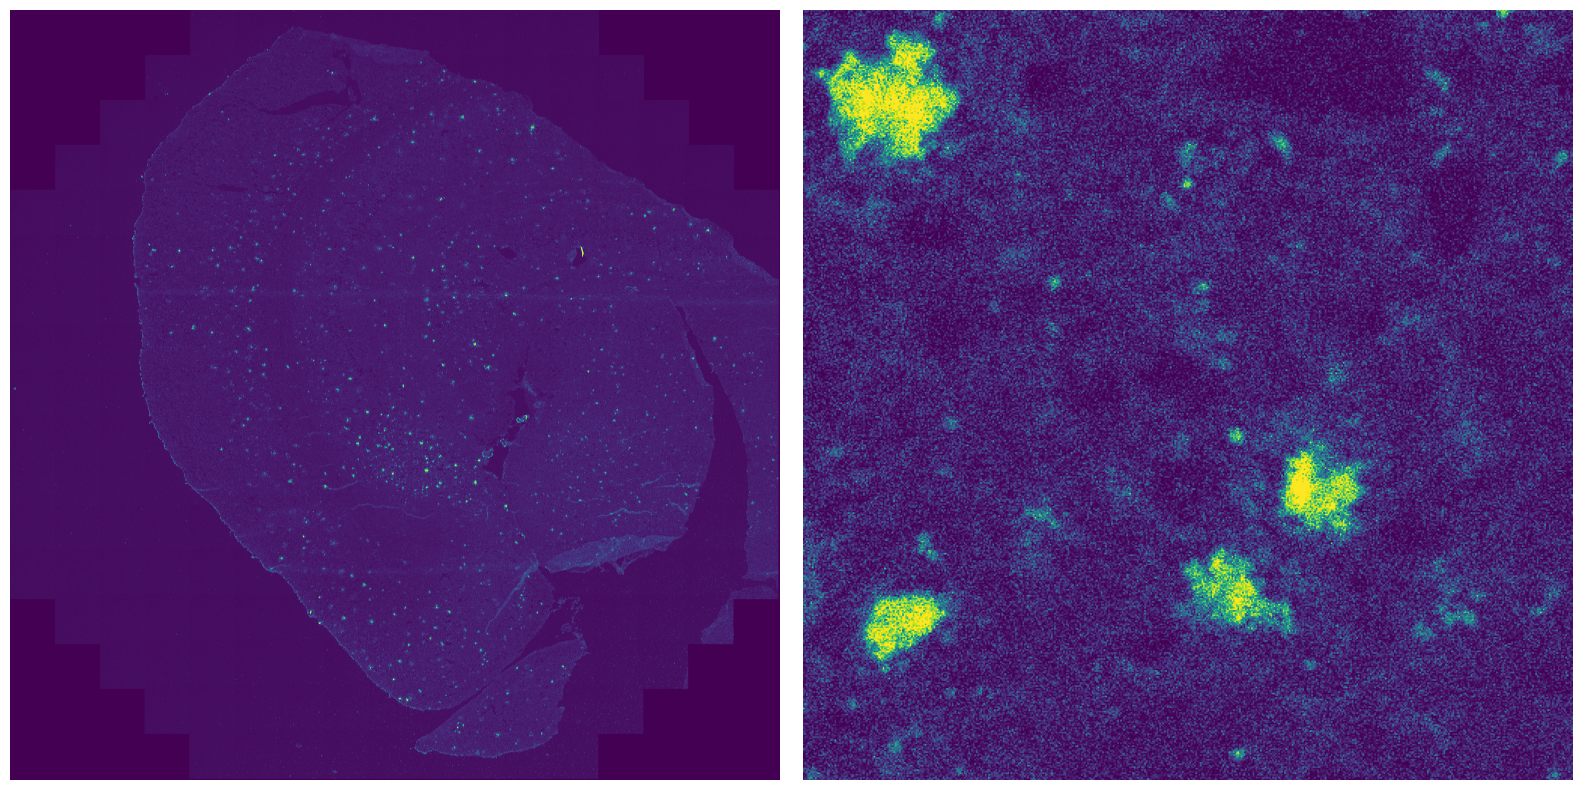

In [33]:
show_image(img, crop_x=8500, crop_y=9400, tile_size=512)

In [34]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [131]:
model

StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=400, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=None, train_tensorboard=True, tr

In [35]:
#img = imread(WSIs[ind])
# img = img / 65535
  #img = img/255

labels, polys = model.predict_instances_big(img, axes='YX', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4))

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 25/25 [00:42<00:00,  1.72s/it]


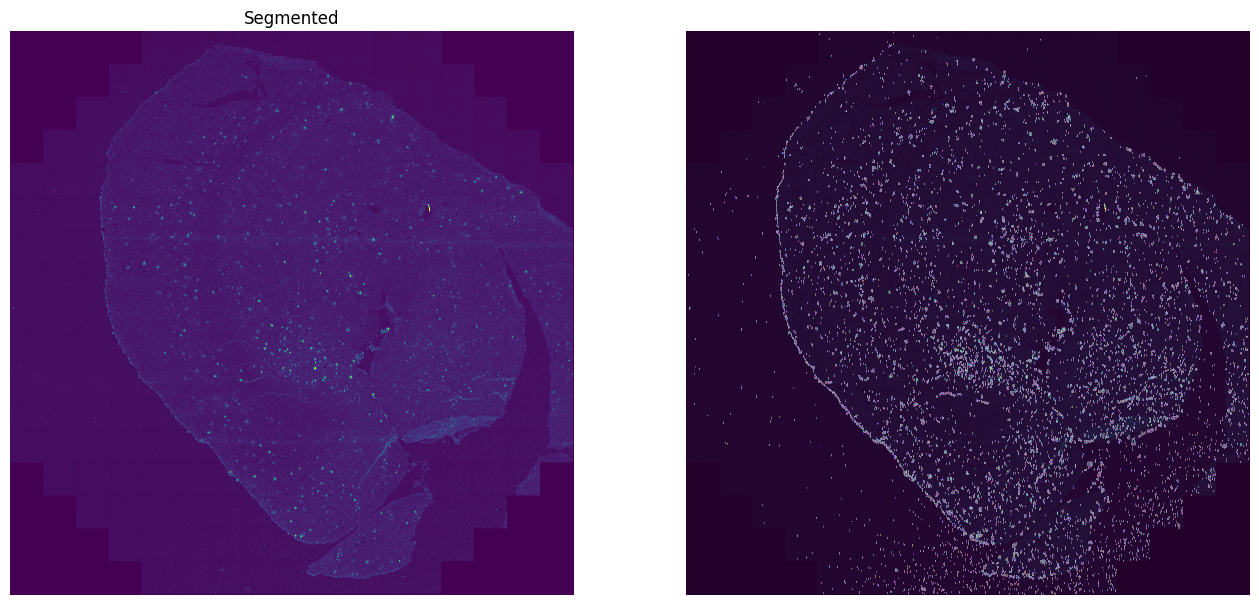

In [36]:
fig, ax = plt.subplots(1,2,figsize = (16, 8))

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('IF')

ax[1].imshow(img)
ax[1].imshow(labels, cmap=cmap, alpha=0.5)
ax[1].axis('off')
ax[0].set_title('Segmented')

plt.show()

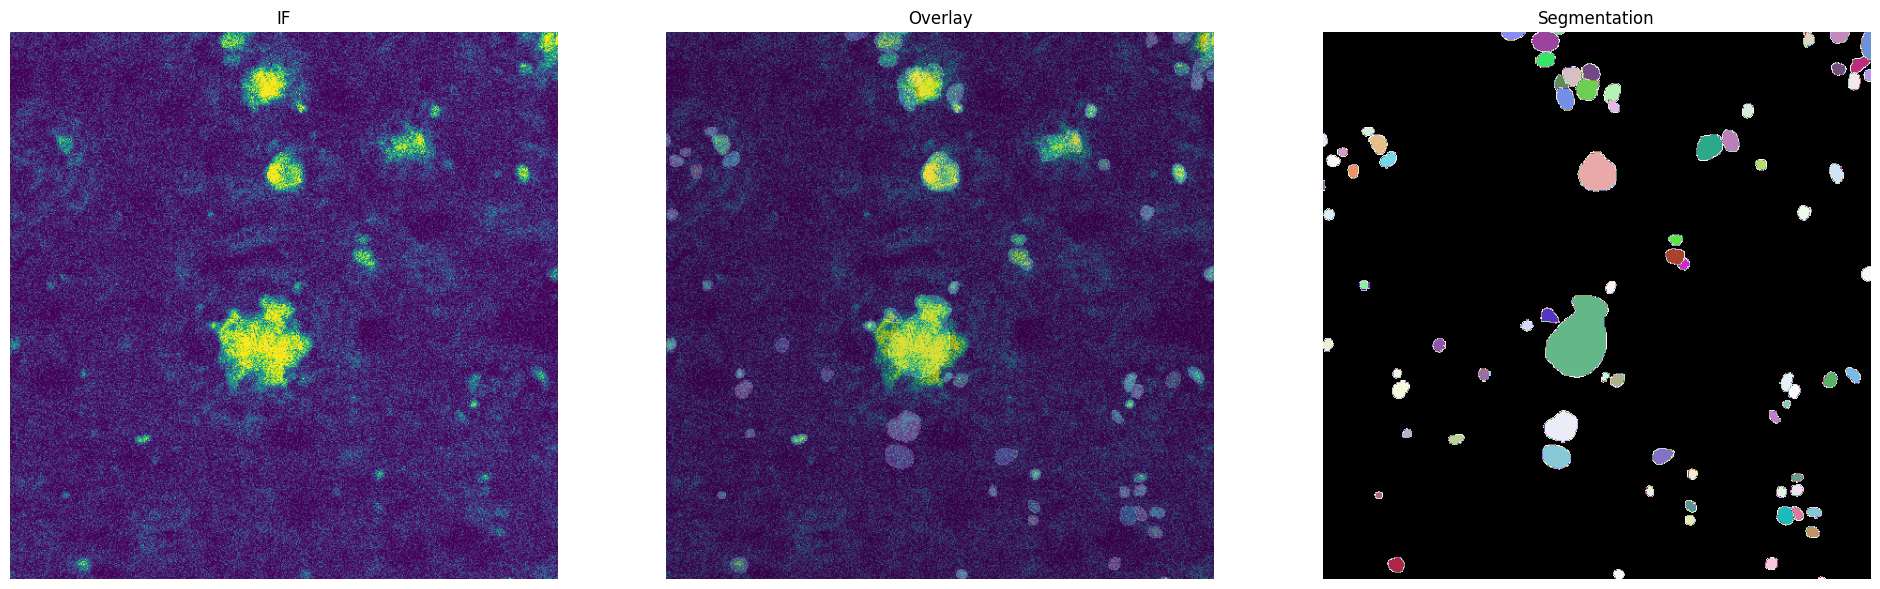

In [38]:
crop_x=8322
crop_y=9167
tile_size=512
cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
cropped_lbls = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

_, ax = plt.subplots(1,3,figsize = (24, 8))

ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('IF')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbls, cmap=cmap, alpha=0.2)
ax[1].axis('off')
ax[1].set_title('Overlay')

ax[2].imshow(cropped_lbls, cmap=cmap)
ax[2].axis('off')
ax[2].set_title('Segmentation')

plt.show()

In [11]:
from scipy.io import loadmat
import h5py
import os

def load_var_from_mat(mat_file_name, varname):

    try:
        data = loadmat(mat_file_name)

        var = data[varname]
    except:
        data = h5py.File(mat_file_name, 'r')

        var = data[varname][()]

    return var

In [12]:
pth = r'C:\Users\Donald\Desktop\AD_IF_Images\AD brain tissue images_ImmunoFluorescence\20231115_Shared\5xFAD 12MO F3-1_IF slide1\combined_ims\coords_for_stardist'

Cy5_coords = load_var_from_mat(os.path.join(pth, 'Cy5_coords.mat'), "Cy5_coords")

IBA_coords = load_var_from_mat(os.path.join(pth, 'IBA_coords.mat'), "IBA_coords")

In [13]:
Cy5_coords

array([[ 1215,  7019],
       [ 1252,  8516],
       [ 1490,  7346],
       ...,
       [16948,  9062],
       [16962,  9057],
       [16983,  8926]], dtype=uint16)

In [24]:
adj_x = [x - crop_x for x in Cy5_coords[:,0]]
adj_y = [y - crop_y for y in Cy5_coords[:,1]]

adj_Cy5_coords = np.transpose(np.array([adj_x, adj_y]))
adj_Cy5_coords = np.array([xy for xy in adj_Cy5_coords if 0 < xy[0] < tile_size and 0 < xy[1] < tile_size])

In [15]:
print(crop_x, crop_y)

12500 12500


Text(0.5, 1.0, 'Overlay')

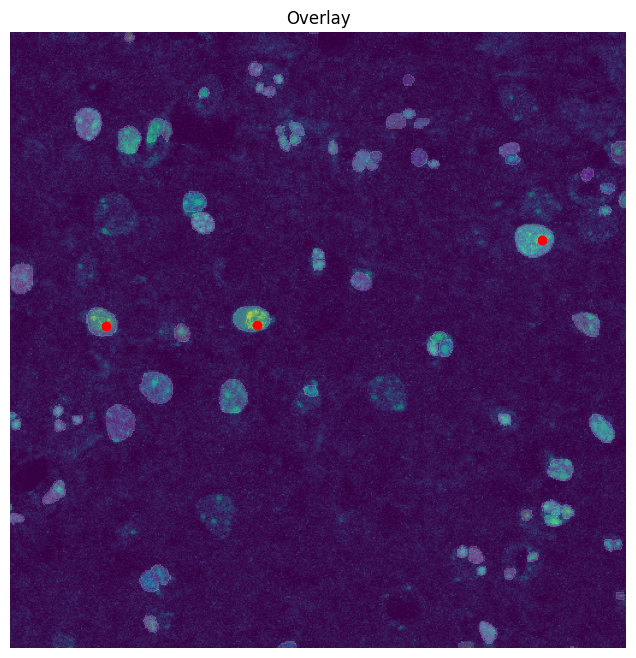

In [16]:
_, ax = plt.subplots(1,1,figsize = (24, 8))

ax.imshow(cropped_img)
ax.imshow(cropped_lbls, cmap=cmap, alpha=0.2)
ax.axis('off')
ax.scatter(adj_Cy5_coords[:,0], adj_Cy5_coords[:,1], c="r")
ax.set_title('Overlay')

In [17]:
adj_Cy5_coords

array([[ 79, 244],
       [205, 243],
       [442, 172]])

In [18]:
def is_point_encompassed(xy_point, set_of_points):
    x, y = xy_point
    min_x, max_x = min(point[0] for point in set_of_points), max(point[0] for point in set_of_points)
    min_y, max_y = min(point[1] for point in set_of_points), max(point[1] for point in set_of_points)
    return min_x <= x <= max_x and min_y <= y <= max_y

In [20]:
in_tile_inds = []
poly_inds = []

in_tile = []
for num, i in enumerate(polys['coord']):
    xy = i
    x_cent = np.mean(xy[0]) - crop_x
    y_cent = np.mean(xy[1]) - crop_y
    xy = np.transpose(xy)
    
    adj_x = [x - crop_x for x in xy[:,0]]
    adj_y = [y - crop_y for y in xy[:,1]]
    xy = np.transpose(np.array([adj_x, adj_y]))
    xy = xy[:, ::-1]

    
    if 0 < x_cent < tile_size and 0 < y_cent < tile_size:
        in_tile.append([xy])
        for xy_cy5 in adj_Cy5_coords:
            
            if is_point_encompassed(xy_cy5, xy):
                in_tile_ind = len(in_tile) - 1
                in_tile_inds.append(in_tile_ind)
                
                poly_inds.append(num)
                print(num, x_cent, y_cent)

42610 172.29914474487305 434.4206085205078
42657 237.93472290039062 201.39768981933594
42830 240.40578079223633 75.7444839477539


In [21]:
in_tile

[[array([[451.61767578, 172.        ],
         [450.68066406, 175.31799316],
         [449.45507812, 178.4017334 ],
         [447.43164062, 180.97460938],
         [444.96630859, 182.96630859],
         [442.40136719, 184.57348633],
         [439.68334961, 185.72058105],
         [436.81298828, 186.14221191],
         [434.        , 186.62719727],
         [431.20727539, 186.03942871],
         [428.36450195, 185.60559082],
         [425.82617188, 184.2331543 ],
         [423.6496582 , 182.3503418 ],
         [421.95361328, 180.04919434],
         [420.64819336, 177.53051758],
         [419.95947266, 174.79284668],
         [419.13305664, 172.        ],
         [419.53881836, 169.12341309],
         [419.92626953, 166.17041016],
         [421.3125    , 163.52258301],
         [423.49951172, 161.49938965],
         [426.14868164, 160.24975586],
         [428.86474609, 159.60241699],
         [431.53125   , 159.58862305],
         [434.        , 159.2220459 ],
         [436.44091797, 1

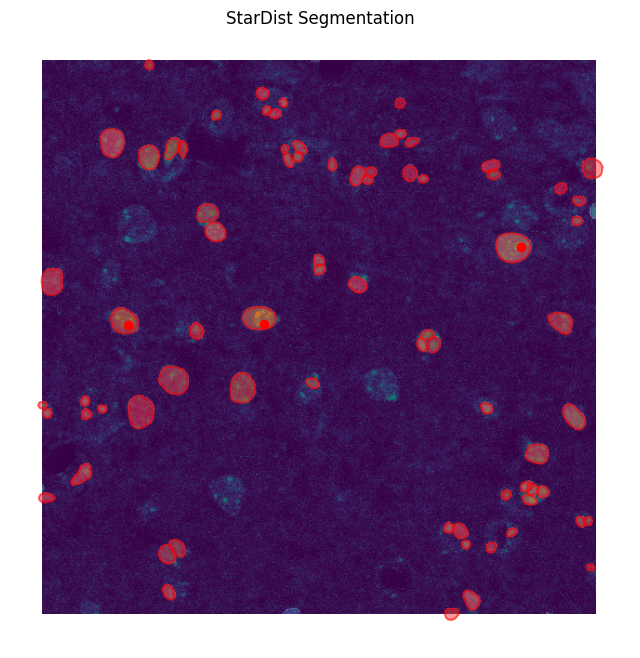

In [22]:
_, ax = plt.subplots(1,1,figsize = (24, 8))

ax.imshow(cropped_img)
ax.imshow(cropped_lbls, cmap=cmap, alpha=0.2)
ax.axis('off')
ax.scatter(adj_Cy5_coords[:,0], adj_Cy5_coords[:,1], c="r")
ax.set_title('Overlay')

for polygon in in_tile:
    x_coords, y_coords = polygon[0][:,0], polygon[0][:,1]
    #print(x_coords, y_coords)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'

    ax.plot(x_coords, y_coords, alpha=0.4, color=color)
    ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('StarDist Segmentation')

plt.show()

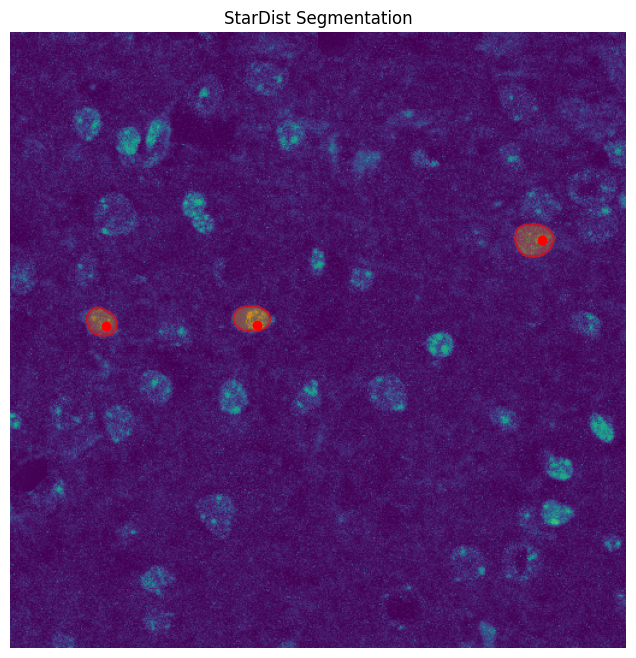

In [23]:
_, ax = plt.subplots(1,1,figsize = (24, 8))

ax.imshow(cropped_img)
# ax.imshow(cropped_lbls, cmap=cmap, alpha=0.2)
ax.axis('off')
ax.scatter(adj_Cy5_coords[:,0], adj_Cy5_coords[:,1], c="r")
ax.set_title('Overlay')

for i, polygon in enumerate(in_tile):
    if i in in_tile_inds:
        x_coords, y_coords = polygon[0][:,0], polygon[0][:,1]
        #print(x_coords, y_coords)
        x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
        y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon
    
        color = 'red'
    
        ax.plot(x_coords, y_coords, alpha=0.4, color=color)
        ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('StarDist Segmentation')

plt.show()

In [147]:
poly_inds

[42610, 42657, 42830]

In [149]:
shapes = polys['coord'][poly_inds]
# print(shapes)

In [150]:
import cv2
def cntarea(cnt):
    cnt = np.array(cnt).astype(np.float32)
    area = cv2.contourArea(cnt)
    return area

In [151]:
for sh in shapes:
    sh = np.transpose(sh)
    area = cntarea(sh)
    print(area)

693.2957949638367
515.2490010261536
456.8840866088867
